# 誘導点に対する Relevance Vector Machine (Variational Sparse Gaussian Process)

---

## セットアップ

### モジュールの読み込み

In [1]:
import numpy as np
import torch
import pyro
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

In [2]:
import sys
sys.path.append("../")

from models import VSGP
from kernels import RBF
from kernels import RVM
from likelihoods import Binary

In [3]:
from matplotlib import pyplot as plt
from matplotlib.colors import Normalize

### 設定

In [4]:
# 乱数シードを固定
pyro.set_rng_seed(4)

In [5]:
# テンソルのdtypeをデフォルトで倍精度に設定
torch.set_default_dtype(torch.float64)

---

## データの生成

In [6]:
centroids = torch.rand(10, 2) * 10 - 5
X = torch.tile(centroids, (10, 1)) + torch.rand(100, 2) * 3 - 1.5
y = torch.tensor([1 if i % 2 == 0 else 0 for i in range(X.shape[0])], dtype = torch.get_default_dtype()).unsqueeze(1)

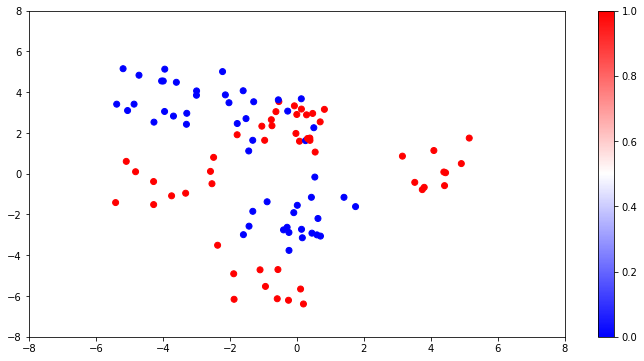

In [7]:
plt.figure(figsize = (12, 6))
plt.scatter(x = X[:, 0], y = X[:, 1], c = y[:, 0], cmap = "bwr")
plt.xlim(-8, 8)
plt.ylim(-8, 8)
plt.colorbar()
plt.show()

---

## 推論

In [8]:
pyro.clear_param_store()

likelihood = Binary()
Z = X[:20, :].clone()
kernel = RVM(RBF(), Z)
estimator = VSGP(Z, 1, kernel, likelihood, whiten = True)
estimator.kernel.X = estimator.Z

svi = SVI(
    estimator.model,
    estimator.guide,
    Adam({"lr": 0.01}),
    loss = Trace_ELBO(retain_graph = True)
)

n_epochs = 1000
for epoch in range(n_epochs):
    loss = svi.step(X, y)
    if epoch % (n_epochs / 10) == 0:
        print(loss)

74.98226654497608
58.12916027344852
48.88991090357678
35.74679023452353
30.718391352324716
27.873736713339326
29.493292022201388
29.085007594358842
31.15251995792562
31.045535560835674


---

## 推論結果

### 予測分布

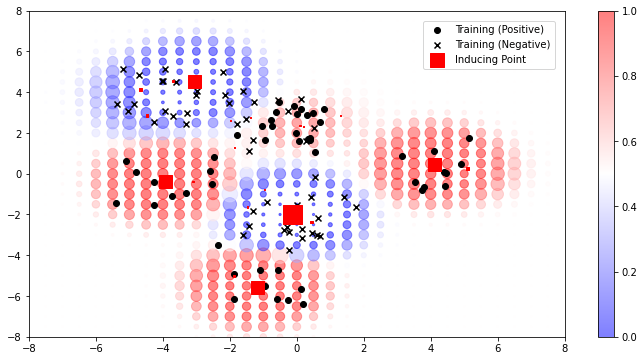

CPU times: user 8.6 s, sys: 834 ms, total: 9.43 s
Wall time: 2.64 s


In [9]:
%%time
with torch.no_grad():
    Xnew = torch.tensor([[x, y] for x in np.linspace(-8, 8, 33) for y in np.linspace(-8, 8, 33)], dtype = torch.get_default_dtype())
    fnew, ynew = estimator(Xnew, 100)
    pnew = torch.sigmoid(fnew)
    pnew_mean = pnew.mean(axis = 0)
    pnew_std = pnew.std(axis = 0)
    
    sr = estimator.kernel.relevance
    sr = (sr - sr.min()) / sr.std() * 100 + 1
    sp = pnew_std[:, 0]
    sp = ((sp - sp.min()) / sp.std()) * 50 + 1

    plt.figure(figsize = (12, 6))
    plt.scatter(
        x = Xnew[:, 0], y = Xnew[:, 1],
        s = sp,
        c = pnew_mean[:, 0], cmap = "bwr", norm = Normalize(vmin = 0, vmax = 1), alpha = 0.5,
        marker = "o"
    )
    plt.colorbar()
    plt.scatter(
        x = X[y[:, 0] == 1, 0], y = X[y[:, 0] == 1, 1],
        c = "black",
        marker = "o",
        label = "Training (Positive)"
    )
    plt.scatter(
        x = X[y[:, 0] == 0, 0], y = X[y[:, 0] == 0, 1],
        c = "black",
        marker = "x",
        label = "Training (Negative)"
    )
    plt.scatter(
        x = estimator.Z[:, 0], y = estimator.Z[:, 1],
        s = sr,
        c = "red",
        marker = "s",
        label = "Inducing Point"
    )
    plt.xlim(-8, 8)
    plt.ylim(-8, 8)
    plt.legend(bbox_to_anchor = (1, 1), loc = "upper right", borderaxespad = 1)
    plt.show()

### ハイパーパラメーター

In [10]:
estimator.kernel.relevance

tensor([2.0895e-01, 6.1032e+00, 7.1242e+00, 1.6700e-01, 1.6456e+00, 4.4361e+00,
        2.7665e+00, 1.3691e+00, 1.1536e+00, 8.6741e-01, 3.2730e-01, 1.5433e+02,
        1.3364e+02, 2.5501e+00, 1.4339e+02, 2.7763e-01, 1.3228e+02, 4.5751e+00,
        1.7239e+00, 3.2072e+02], grad_fn=<AddBackward0>)

In [11]:
estimator.kernel.kernel.scale

tensor(0.9108, grad_fn=<AddBackward0>)

### 変分パラメーター

In [12]:
estimator.Z

Parameter containing:
tensor([[-1.3701,  2.7691],
        [-4.6703,  4.1389],
        [ 5.0979,  0.2416],
        [-1.8741,  1.3079],
        [-3.1037, -0.3873],
        [-4.4779,  2.8527],
        [-1.8624, -5.0086],
        [-0.9688, -0.7673],
        [ 0.0912,  2.3664],
        [-1.4672, -1.6321],
        [ 1.3027,  2.8770],
        [-3.0593,  4.5302],
        [ 4.1153,  0.4464],
        [-3.6903,  4.5327],
        [-3.9300, -0.3891],
        [-1.9879,  2.6204],
        [-1.1775, -5.5719],
        [ 0.4406, -2.3586],
        [ 0.2028,  2.3158],
        [-0.1220, -1.9989]], requires_grad=True)

In [13]:
estimator.u_loc

Parameter containing:
tensor([[-0.1283, -1.7301,  1.2132,  0.3315,  1.2461, -0.3992,  1.2647, -1.4041,
          1.1185, -0.1122, -0.1226, -0.6435,  0.0633,  0.0105, -0.1035, -0.0927,
          0.3369, -0.2240,  0.1143, -0.0559]], requires_grad=True)

In [14]:
estimator.u_cov

tensor([[[ 3.4119e-01, -4.1742e-02, -1.3293e-01, -3.5114e-03, -2.7747e-02,
           1.4782e-02,  7.3003e-03,  3.7270e-02, -1.7431e-01,  1.6090e-04,
           1.5691e-02, -1.6279e-02, -2.7990e-02, -2.2926e-02, -5.6712e-03,
          -6.4299e-02,  3.1748e-02,  2.8713e-02, -2.1873e-03,  7.3343e-02],
         [-4.1742e-02,  4.1956e-01,  2.2077e-02,  2.6768e-02, -1.1693e-02,
          -1.1117e-01, -9.8365e-02, -2.2573e-03,  1.1213e-01,  2.8271e-02,
          -6.2431e-02, -6.7584e-02, -4.2552e-02,  2.4182e-02, -3.1660e-02,
           2.0596e-02, -4.2466e-02, -1.0015e-01,  1.2393e-02, -1.9943e-02],
         [-1.3293e-01,  2.2077e-02,  2.5632e-01,  5.7406e-02, -1.5929e-02,
          -2.9368e-03, -1.5491e-02,  8.0528e-03,  9.6660e-02, -3.7138e-03,
           4.6381e-02, -1.6475e-02, -8.6065e-02, -1.8464e-02,  1.4827e-02,
           3.7178e-02,  9.0562e-03, -2.5522e-03, -6.6503e-02,  3.9392e-03],
         [-3.5114e-03,  2.6768e-02,  5.7406e-02,  6.9479e-01, -2.2862e-01,
          -5.8411e-02,